In [130]:
import hashlib

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
import matplotlib.pyplot as plt


from tqdm import tqdm
from scipy import stats

# A/Bテストについての発展的な話題

## A/Aテスト：A/Bテスト設計の妥当性を確認する
### A/Bテストは頻繁に「失敗」する

In [2]:
df_cluster_trial= pd.read_csv('../data/ch3_cluster_trial.csv')
df_cluster_trial

,uid,is_treatment,is_click
0,0,1,1
1,0,1,1
2,0,1,1
3,0,1,0
4,0,1,1
...,...,...,...
10405,199,0,0
10406,199,0,0
10407,199,0,0
10408,199,0,0


In [3]:
result = smf.ols("is_click ~ is_treatment", data=df_cluster_trial).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               is_click   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     92.32
Date:                Mon, 22 May 2023   Prob (F-statistic):           9.06e-22
Time:                        22:46:58   Log-Likelihood:                -7508.9
No. Observations:               10410   AIC:                         1.502e+04
Df Residuals:                   10408   BIC:                         1.504e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4592      0.007     67.130      0.000       0.446       0.473
is_treatment     0.0938      0.010      9.609      0.000       0.075       0.113
==============================================================================
Omnibus:                    36547.924   Durbin-Watson:                   1.357
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1673.995
Skew:                          -0.021   Prob(JB):                         0.00
Kurtosis:                       1.036   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### A/Aテストをやってみる
読み込み

In [4]:
df_aatest = pd.read_csv('../data/ch3_aatest_trial.csv')
df_aatest

,uid,is_treatment,is_click
0,0,1,0
1,1,1,0
2,2,1,1
3,3,0,1
4,4,0,1
...,...,...,...
9995,9995,1,1
9996,9996,1,1
9997,9997,0,1
9998,9998,1,0


A/Aテストの分析

In [5]:
result = smf.ols("is_click ~ is_treatment", data =df_aatest).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4988,0.007,70.327,0.000,0.485,0.513
is_treatment,0.0102,0.010,1.015,0.310,-0.009,0.030


### 例：A/Aテストのリプレイ(成功ケース)

In [67]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2


df_aatest = pd.read_csv('../data/ch3_aatest_trial.csv')
rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{rng.integers(0, 99999)}'
    df_aatest['is_treatment_in_aa'] = df_aatest['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_aatest).fit()
    pvalue = result.pvalues['is_treatment_in_aa']
    # 情報の格納
    replays.append(pvalue)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 31.92it/s]


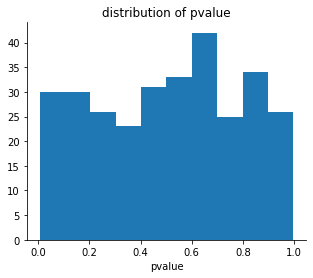

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

In [70]:
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.04413487466257898, pvalue=0.5872365643652379)

## 状況に応じたA/Bテストのモデリング

### クラスターA/BテストCluster A/B Test 

#### クラスターA/BテストデータにおけるA/Aテストのリプレー(失敗ケース)

In [3]:
df_cluster = pd.read_csv('../data/ch3_cluster_trial.csv')
df_cluster

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


In [4]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2


rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{rng.integers(0, 99999)}'
    df_cluster['is_treatment_in_aa'] = df_cluster['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_cluster).fit()
    pvalue = result.pvalues['is_treatment_in_aa']
    # 情報の格納
    replays.append(pvalue)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.15it/s]


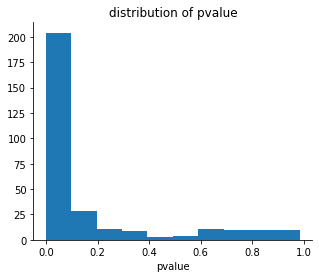

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
[spin.set_visible(False) for spin in list(ax.spines.values())]
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

In [75]:
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.5940350827267781, pvalue=1.5923843685272902e-101)

#### クラスターA/Bテストの実装

- データの読み込み

In [8]:
# データの読み込み
df_cluster_trial= pd.read_csv('../data/ch3_cluster_trial.csv')
df_cluster_trial

,uid,is_treatment,is_click
0,0,0,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
10635,199,1,0
10636,199,1,0
10637,199,1,1
10638,199,1,0


- 分散を補正する

In [9]:
# 分散を補正して推定
result = smf.ols("is_click ~ is_treatment", data=df_cluster).fit()
result_correted = result.get_robustcov_results('cluster', groups=df_cluster['uid'])
result_correted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               is_click   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.2906
Date:                Sat, 27 May 2023   Prob (F-statistic):              0.590
Time:                        22:34:02   Log-Likelihood:                -7718.2
No. Observations:               10640   AIC:                         1.544e+04
Df Residuals:                   10638   BIC:                         1.546e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5216      0.033     15.632      0.000       0.456       0.587
is_treatment    -0.0232      0.043     -0.539      0.590      -0.108       0.062
==============================================================================
Omnibus:                    36644.980   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1769.607
Skew:                          -0.032   Prob(JB):                         0.00
Kurtosis:                       1.003   Cond. No.                         2.86
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

#### クラスターA/BテストデータにおけるA/Aテストのリプレー(成功ケース)

In [47]:
def assign_treatment_randomly(uid: int, salt: str):
    return int(hashlib.sha256(f"{salt}_{uid}".encode()).hexdigest(), 16) % 2


rng = np.random.default_rng(seed=0)
replays = []
for i in tqdm(range(300)):
    # 擬似的な割当
    salt = f'salt{rng.integers(0, 99999)}'
    df_cluster['is_treatment_in_aa'] = df_cluster['uid'].apply(assign_treatment_randomly, salt=salt)
    # 擬似的な割当の下での分析
    result = smf.ols("is_click ~ is_treatment_in_aa", data=df_cluster).fit()
    result_correted = result.get_robustcov_results('cluster', groups=df_cluster['uid'])
    pvalue = result_correted.pvalues[result_correted.model.exog_names.index('is_treatment_in_aa')]
    # 情報の格納
    replays.append(pvalue)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.05it/s]


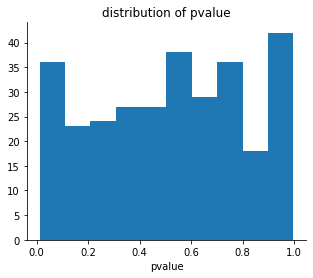

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(replays)
[spin.set_visible(False) for spin in list(ax.spines.values())]
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_facecolor("none")
ax.set_xlabel('pvalue')
ax.set_title('distribution of pvalue')
plt.show()

In [49]:
stats.kstest(replays, 'uniform', args=(0, 1))

KstestResult(statistic=0.05899866564664091, pvalue=0.237770780294283)

### 層化A/Bテスト Stratified A/B Test

#### バランステスト失敗するパターン

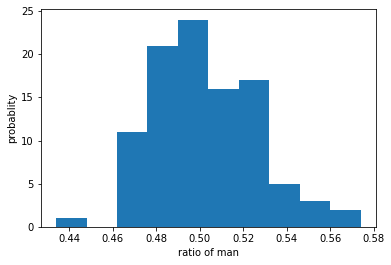

In [14]:
ratio = [np.random.choice([0, 1], p = [0.5, 0.5], size = 500).mean() for _ in range(100)]
plt.hist(ratio)
plt.xlabel('ratio of man')
plt.ylabel('probablity')
plt.show()

#### 層化A/Bテストの割当の実装

In [77]:
df_titanic = sns.load_dataset('titanic')[['survived', 'sex', 'age', 'pclass']]
df_titanic

,survived,sex,age,pclass
0,0,male,22.0,3
1,1,female,38.0,1
2,1,female,26.0,3
3,1,female,35.0,1
4,0,male,35.0,3
...,...,...,...,...
886,0,male,27.0,2
887,1,female,19.0,1
888,0,female,NaN,3
889,1,male,26.0,1


In [108]:
df_titanic.groupby(['sex', 'pclass'])

In [109]:
# グループごとに無作為抽出による割当を行う関数
def stratified_assiginment(df_group: pd.DataFrame, ratio_treat: float, rng: np.random.Generator, column_name = 'is_treat',):
    num_samples = round(len(df_group) * ratio_treat)
    df_group[column_name] = 0
    treat_indices = rng.choice(df_group.index, num_samples, replace=False)
    df_group.loc[treat_indices, column_name] = 1
    return df_group

# groupbyメソッドを用いて無作為抽出
rng = np.random.default_rng(11)
df_titanic_assigned = df_titanic.groupby(['sex', 'pclass']).apply(stratified_assiginment, ratio_treat = 0.3, column_name = 'is_treat', rng = rng)

In [110]:
df_titanic_assigned

,survived,sex,age,pclass,is_treat
0,0,male,22.0,3,0
1,1,female,38.0,1,0
2,1,female,26.0,3,1
3,1,female,35.0,1,0
4,0,male,35.0,3,0
...,...,...,...,...,...
886,0,male,27.0,2,1
887,1,female,19.0,1,0
888,0,female,NaN,3,0
889,1,male,26.0,1,0


In [111]:
df_titanic_assigned.groupby(['sex', 'pclass'])['is_treat'].mean()

sex     pclass
female  1         0.297872
        2         0.302632
        3         0.298611
male    1         0.303279
        2         0.296296
        3         0.299712
Name: is_treat, dtype: float64

#### 層化A/Bテストの分析の実装

- データの読み込み

In [2]:
df_stratified = pd.read_csv('../data/ch3_stratified_trial.csv')
df_stratified

,is_treatment,group_name,y
0,1,0,-5.166615
1,0,0,-6.641471
2,1,0,-2.885075
3,1,0,-4.307144
4,0,0,-4.115966
...,...,...,...
99,0,1,5.129373
100,1,1,5.164918
101,1,1,4.022947
102,0,1,5.027952


- グループごとの平均的なアウトカム

In [3]:
df_stratified.groupby(['group_name', 'is_treatment']).mean()

y
group_name is_treatment          
0          0            -5.486896
           1            -4.577039
1          0             4.242082
           1             4.288309

- 通常の回帰分析

In [8]:
result = smf.ols("y ~ is_treatment", data=df_stratified).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.6942,0.601,-2.817,0.006,-2.887,-0.501
is_treatment,-0.1247,0.914,-0.136,0.892,-1.938,1.689


- グループダミーを追加する

In [10]:
result = smf.ols("y ~ is_treatment + C(group_name)", data=df_stratified).fit()
result.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.3498,0.148,-36.252,0.000,-5.643,-5.057
C(group_name)[T.1],9.3772,0.198,47.266,0.000,8.984,9.771
is_treatment,0.6135,0.192,3.200,0.002,0.233,0.994


## 処置と割当の不一致 A/B テストにおける Non-compliance

- データのimport

In [95]:
# データの読み込み
df_noncompliance= pd.read_csv('../data/ch3_noncompliance_abtest.csv')
df_noncompliance

,assignment,x,is_deliver,purchase
0,1.0,0.143069,1.0,12272.717011
1,1.0,0.019232,1.0,11289.104060
2,1.0,0.006487,1.0,9130.497979
3,0.0,0.129664,0.0,10276.942082
4,0.0,0.000423,0.0,10131.093488
...,...,...,...,...
995,1.0,-0.114975,0.0,9613.864469
996,0.0,0.066775,0.0,11455.559740
997,0.0,0.083205,0.0,10423.608120
998,0.0,0.160481,0.0,11903.856890


#### Intent to treatな分析

In [100]:
# intent to treatの分析
result = smf.ols("purchase ~ assignment", data=df_noncompliance).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9996.7694,63.888,156.474,0.000,9871.400,1.01e+04
assignment,185.8228,87.183,2.131,0.033,14.740,356.905


In [97]:
df_noncompliance.groupby('assignment')['is_deliver'].mean()

assignment
0.0    0.000000
1.0    0.487896
Name: is_deliver, dtype: float64

####  LATEの導出によるnon-complianceへの対処

In [98]:
iv = IV2SLS.from_formula("purchase ~ 1 + [is_deliver ~ assignment] + x", df_noncompliance).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,9997.8,43.469,230.00,0.0000,9912.6,1.008e+04
x,9527.1,306.24,31.110,0.0000,8926.9,1.013e+04
is_deliver,583.91,124.77,4.6799,0.0000,339.37,828.46


- first stage確認

In [99]:
iv.first_stage

,is_deliver
R-squared,0.3129
Partial R-squared,0.3109
Shea's R-squared,0.3109
Partial F-statistic,521.27
P-value (Partial F-stat),0.0000
Partial F-stat Distn,chi2(1)
==========================,===========
Intercept,4.106e-05
,(0.0244)
x,0.3684


# 共変量を入れて分析をする

In [127]:
# サブサンプル分割
df = pd.read_csv('../data/lenta_dataset.csv')
df

,is_treatment,response_att,food_share_15d,age,is_women
0,1,0,0.0000,33.0,1
1,0,0,0.0000,63.0,1
2,1,0,0.0000,51.0,1
3,0,0,0.0000,38.0,1
4,1,0,0.5105,20.0,1
...,...,...,...,...,...
49995,1,0,0.0000,60.0,1
49996,0,0,0.0000,26.0,0
49997,1,0,0.8461,28.0,1
49998,1,0,0.0000,19.0,1


In [141]:
result_with_covariates = smf.ols("response_att ~ is_treatment + food_share_15d + age + is_women", data=df).fit()
result_with_covariates.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0539,0.005,10.555,0.000,0.044,0.064
is_treatment,0.0072,0.003,2.285,0.022,0.001,0.013
food_share_15d,0.1713,0.003,51.131,0.000,0.165,0.178
age,-0.0003,9.3e-05,-3.047,0.002,-0.000,-0.000
is_women,0.0033,0.003,1.157,0.247,-0.002,0.009


- A/Bテストの結果再掲

In [142]:
result_plain = smf.ols("response_att ~ is_treatment ", data=df).fit()
result_plain.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1024,0.003,36.412,0.000,0.097,0.108
is_treatment,0.0091,0.003,2.809,0.005,0.003,0.015


# 施策効果の異質性 ~ どこで効果があるのか知る

## セグメントごとにサブサンプルに分割する

In [120]:
# サブサンプル分割
df = pd.read_csv('../data/lenta_dataset.csv')
df_men = df.loc[df['is_women'] == 0, :]
df_women = df.loc[df['is_women'] == 1, :]

In [112]:
result_men = smf.ols("response_att ~ is_treatment", data=df_men).fit()
result_men.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.021,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.543,0.011,0.003,0.024


In [113]:
result_women = smf.ols("response_att ~ is_treatment", data=df_women).fit()
result_women.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1032,0.004,29.006,0.000,0.096,0.110
is_treatment,0.0065,0.004,1.583,0.113,-0.002,0.014


In [117]:
# 推定した結果をまとめて表示
summary_col([result_men, result_women], model_names=('only men model', 'only women model'), stars=True)

,only men model,only women model
Intercept,0.1010***,0.1032***
,(0.0046),(0.0036)
is_treatment,0.0135**,0.0065
,(0.0053),(0.0041)
R-squared,0.0003,0.0001
R-squared Adj.,0.0003,0.0000


## セグメントの交差項を入れて分析を行う

In [123]:
df[['is_women']]

,is_women
0,1
1,1
2,1
3,1
4,1
...,...
49995,1
49996,0
49997,1
49998,1


In [125]:
# 推定
result_hetero = smf.ols("response_att ~ is_treatment + is_women + is_treatment * is_women", data=df).fit()
# 推定結果の表示
result_hetero.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1010,0.005,22.184,0.000,0.092,0.110
is_treatment,0.0135,0.005,2.562,0.010,0.003,0.024
is_women,0.0022,0.006,0.380,0.704,-0.009,0.014
is_treatment:is_women,-0.0070,0.007,-1.050,0.294,-0.020,0.006


# 捨てる

## A/Bテストの弱点

## 3.2 A/A テスト：A/B テストのクオリティを担保する
### 3.2.1 A/B テストは頻繁に「失敗」する

[] イメージ絵の作成

[X] シミュレーションデータの作成、そのデータを表示

#### シミュレーションデータを作成する

In [3]:
def gen_simulated_data(n: int, delta: float, seed: int=1) -> pd.DataFrame:
    np.random.seed(seed=seed)
    assignment = np.random.choice([0, 1], size=n)
    num_visits = np.random.randint(low=1, high=1000, size=n)
    ctr = np.random.uniform(0, 1 - delta, size=n)
    ctr[assignment==1] += delta
    uid_vec = np.repeat(range(n), num_visits, axis=0)
    treatment_vec = np.repeat(assignment, num_visits, axis=0)
    ctr_vec = np.repeat(ctr, num_visits, axis=0)
    clicks_vec = reduce(lambda a, b: np.r_[a, b], [np.random.choice([0, 1], size=num_visits[i], p=[1 - ctr[i], ctr[i]]) for i in np.arange(n)])
    df = (
        pd.DataFrame(
          np.c_[uid_vec, treatment_vec, clicks_vec], 
          columns=['uid', 'is_treatment', 'is_click']
        )
        .astype({'uid': int, 'is_treatment': int, 'is_click': int})
    )
    return df

In [4]:
df = gen_simulated_data(n=300, delta=0, seed=10)
df

,uid,is_treatment,is_click
0,0,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
147151,299,0,1
147152,299,0,0
147153,299,0,1
147154,299,0,0


#### シミュレーションデータに基づき分析を行う

In [5]:
result = smf.ols("is_click ~ is_treatment", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               is_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     27.33
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           1.72e-07
Time:                        22:32:04   Log-Likelihood:            -1.0677e+05
No. Observations:              147156   AIC:                         2.135e+05
Df Residuals:                  147154   BIC:                         2.136e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4841      0.002    264.665   

### 3.2.2 A/A テスト

[] 実験の絵を描く

#### シミュレーションデータを作成する

In [6]:
def gen_simulated_data_aa(n: int, delta: float, seed: int=1) -> pd.DataFrame:
    np.random.seed(seed=seed)
    uids = np.arange(n)
    assignments = np.random.choice([0, 1], size=n)
    ctrs = np.random.uniform(0, 1 - delta, size=n)
    ctrs[assignments==1] += delta
    clicks = reduce(lambda a, b: np.r_[a, b], [np.random.choice([0, 1], p=[1 - ctrs[i], ctrs[i]]) for i in np.arange(n)])
    df = (
        pd.DataFrame(
          np.c_[uids, assignments, clicks], 
          columns=['uid', 'is_treatment', 'is_click']
        )
        .astype({'uid': int, 'is_treatment': int, 'is_click': int})
    )
    return df

In [7]:
df = gen_simulated_data_aa(n=300, delta=0, seed=0)
df

,uid,is_treatment,is_click
0,0,0,0
1,1,1,1
2,2,1,0
3,3,0,0
4,4,1,1
...,...,...,...
295,295,0,0
296,296,0,1
297,297,0,1
298,298,1,1


#### A/Aテストの分析を行う

In [8]:
result = smf.ols("is_click ~ is_treatment", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               is_click   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2066
Date:                Tue, 18 Oct 2022   Prob (F-statistic):              0.650
Time:                        22:32:04   Log-Likelihood:                -217.53
No. Observations:                 300   AIC:                             439.1
Df Residuals:                     298   BIC:                             446.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5000      0.041     12.133   

### 3.2.3 A/A テストのリプレー

In [10]:
# def assign_treatment_randomly(uid: int, salt: str):
#     return int(hashlib.sha256(f"{salt}user{uid}".encode()).hexdigest(), 16) % 2

# def assign_treatment_by_uid(dfx: pd.DataFrame, seed: int = 1, column_name = 'is_treatment_in_aa'):
#     np.random.seed(seed=seed)
#     salt = ''.join(np.random.choice(ALPHABET, size=10))
#     dfx[column_name] = np.vectorize(assign_treatment_randomly, otypes=[float])(uid=dfx['uid'].astype(int), salt = salt)

# replays = []
# for i in tqdm(range(500)):
#     assign_treatment_by_uid(df, seed=i, column_name = 'is_treatment_in_aa')
#     result_user = get_test_result_plain_from_simulated_df(dfx=df.groupby('uid').mean(), column_treatment='is_treatment_in_aa', column_click='is_click')
#     result_impression = get_test_result_plain_from_simulated_df(dfx=df, column_treatment='is_treatment_in_aa', column_click='is_click')
#     result_delta = get_test_result_delta_from_simulated_df(dfx=df, column_treatment='is_treatment_in_aa', column_click='is_click', column_uid = 'uid')
#     result_robust = get_test_result_cluster_robust_from_simulated_df(dfx=df, column_treatment='is_treatment_in_aa', column_click='is_click', column_uid = 'uid')
#     replays.append([
#         i, result_impression.pvalue, result_user.pvalue, result_delta.pvalue, result_robust.summary2().tables[1].loc['is_treatment_in_aa', 'P>|t|']
#     ])
# replays_df = pd.DataFrame(replays, columns=['i', 'impression', 'user', 'delta', 'robust'])

## 3.3 柔軟な A/B テストの設計

### 3.3.1 クラスター A/B テスト

#### シミュレーションデータを作成する

####　A/Aテストによる分析設計の検証

### 3.3.2 層化 A/B テスト

## 3.4 施策効果の異質性

## A/Bテストをどのように解釈するか？

### 共変量の取り扱い/交差項の導入

#### Example:共変量の取り扱い/交差項の導入

viberを普段ツールとして使っているユーザーにおいては効果が変わるかも？

→　変わった

In [ ]:
result = smf.ols("response_att ~ C(is_treatment, Treatment(reference=0)) * response_viber", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           response_att   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     41.48
Date:                Sun, 20 Feb 2022   Prob (F-statistic):           8.60e-27
Time:                        15:44:44   Log-Likelihood:            -1.6718e+05
No. Observations:              678448   AIC:                         3.344e+05
Df Residuals:                  678444   BIC:                         3.344e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [ ]:
result = smf.ols("response_att ~ C(is_treatment, Treatment(reference=0)) * age", data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           response_att   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     32.92
Date:                Sun, 20 Feb 2022   Prob (F-statistic):           2.86e-21
Time:                        15:47:36   Log-Likelihood:            -1.6660e+05
No. Observations:              675264   AIC:                         3.332e+05
Df Residuals:                  675260   BIC:                         3.332e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

### 実施施策のノン・コンプライアンス

A/BテストでわかるのはATE/LATE? 結局分析手法による.

- intent to treat (ふつーに回帰)
- late about compilier (二段階最小二乗法)

In [16]:
from scipy import stats

In [21]:
stats.binom_test(x=80, n=12080, p=728/128668, alternative='greater')

0.09045856714500448